Load necessary packages

In [2]:
from matplotlib import rcParams, ticker, pyplot as plt
import numpy as np
from glob import glob
import parse
import math
import scipy.interpolate as interpolate
from superrad.ultralight_boson import UltralightBoson
from astropy.cosmology import Planck18 as cosmo

#these are just parameters for plots
mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.family': 'DejaVu Sans',
    'font.size': 24
}
rcParams.update(mplparams)
rcParams['figure.figsize'] = 6, 3.5

##useful constants
year=31556926 #one year in seconds
G_SI = 6.674e-11  # m^3 kg^-1 s^-2
C_SI = 299792458  # m s^-1
HBAR_SI = 1.054571e-34  # kg m^2 s^-2*s
PC_SI = 3.08567758e16  # m
MSUN_SI = 1.9891e30  # kg
EV_SI = 1.602176565e-19  # kg (m s^-1)^2
MPL_SI = np.sqrt(HBAR_SI * C_SI / G_SI) #planck mass

In [4]:
#Get PSDs (this assumes PSD files are given in format "S_h_{model}.txt"
#for LIGO and ET I used data files @:
#aLIGO: https://dcc.ligo.org/LIGO-T1800044-v3/public #note that what is found here is the ASD (i.e. the square root of the PSD), not the PSD
#ET-D: https://www.et-gw.eu/index.php/etsensitivities#datafiles
#for LISA I used eq.1 in https://arxiv.org/abs/1803.01944 but without the galactic noise term (S_c) for simplicity

psd_path='PSDs/S_h_{model}.txt'
psd_paths=glob(psd_path.format(model='*'))

psd_data={}

for path in psd_paths:
    label = parse.parse(psd_path, path)['model']
    psd_data[label] = np.loadtxt(path)

print(psd_data.keys())

dict_keys(['aLIGO', 'LISA', 'ETD'])


## SNR calculation

In [5]:
def SNRav(hav, f, PSD, tgw, Tobs = 4, fmin=None, fmax=None):
    '''
    Quick and dirty calculation of "angle-averaged" Signal-to-Noise ratio (SNR).
    We assume signal is of the form h(t)~(h0/(1+t/tgw))(F_+*(1+cos^2\iota)*cos(\omega_gw t+\phi)/2+F_x*cos\iota)*sin(\omega_gw t+\phi)) and assume observation starts right after reaching the superradiant saturation (i.e. t=0).
    Since the signal is nearly monochromatic we approximate the SNR as SNR^2~2/S_n(f)\int_0^Tobs h(t)^2 (eq. 1 in https://arxiv.org/pdf/1808.07055.pdf, which comes from eq. 4.3 in https://journals.aps.org/prd/abstract/10.1103/PhysRevD.57.7089),
    therefore SNR\propto h0*sqrt(Teff/S_n(f)) (after averaging over the sky, polarization angle, inclination and phase \phi) where Teff=tgw*Tobs/(tgw+Tobs). The proportionaly factor can be found in e.g. eqs. 81 and 84 in https://arxiv.org/pdf/2108.01167.pdf, as I also discuss below.
    More details can be found in the Mathematica notebook "SNR_calc.nb" in the school repository.
    For Tobs>>tgw this gives SNR\propto h0*sqrt(Tobs/S_n(f)) whereas for Tobs<<tgw this gives SNR \propto  h0*sqrt(tgw/S_n(f)).
    For scalar fields the condition Tobs<<tgw is almost always true in the LIGO and LISA band, but not necessarily for vector fields.
    For more accurate results one should consider the full time-domain signal, Fourier transform it, and then use standard formulas for the SNR (e.g. eq. A2 in https://arxiv.org/pdf/2211.03845.pdf).

    Arguments
    ---------
    hav: float
        angle averaged GW amplitude.

    f: float
        frequency in hz.

    PSD: float, array
        PSD. Format: 0: frequency; 1: PSD.

    tgw: float
        half-life time of the signal in the detector frame in seconds

    Tobs: float
        observation time in years.

    fmin: float
        set min frequency (def. None, use min in PSD).

    fmax: float
        set max frequency (def. None, use max in PSD).

    Returns
    -------
    SNR: float
        SNR of the signal.
    '''
    if Tobs < 0:
        Tobs_seconds=0
    else:
        Tobs_seconds=Tobs*year #observation time in seconds

    Teff=tgw*Tobs_seconds/(tgw+Tobs_seconds)

    Sn = interpolate.interp1d(PSD[:,0],PSD[:,1])

    if fmin==None:
        fmin=min(PSD[:,0])
    elif fmin<min(PSD[:,0]):
        raise ValueError("minimun frequency smaller than available in the PSD data. Increase fmin")

    if fmax==None:
        fmax=max(PSD[:,0])
    elif fmax>max(PSD[:,0]):
        raise ValueError("maximum frequency larger than available in the PSD data. Decrease fmax")


    if f < fmin or f > fmax:
        SNR=0
        #print('input frequency outside the range: [fmin=%.2e, fmax=%.2e]. Setting SNR=0.'%(fmin,fmax))
    else:
        ASD=np.sqrt(Sn(f))
        SNR=hav*np.sqrt(Teff)/ASD

    return SNR


# SNR for scalar clouds

In [6]:
#initialize scalar (spin 0) cloud model
spin0 = UltralightBoson(spin=0, model="relativistic")

### Requiring that $\tau_{\rm sat}<t_z$
Here $\tau_{\rm sat}$ is the time it takes for the boson cloud to grow up to saturation and $t_z$ is the age of the Universe at a given redshift z. This constraint ensures that a boson cloud has time to grow within the age of the Universe (this is just an approximation, one could chose other more relevant astrophysical timescales)

In [7]:
#loop over different values of (initial) BH mass and distance to compute SNR, given initial dimensionless BH spin and M\mu.
logMmin=0 #min source frame BH mass, written as log10(M)
logMmax=9 #max source frame BH mass, written as log10(M)
zmin=0.0001 #min cosmo redshift
zmax=5.5 #max cosmo redshift

chi_bh=0.9 #dimensionless BH spin
alpha=0.25 #M*\mu

Tobs=4 #observation time in years

SNRLISA=[]
SNRLIGO=[]
SNRET=[]

for z in np.linspace(zmin,zmax, num=200):
    for log10mbh in np.linspace(logMmin, logMmax, num=60):

        #compute cloud
        cloud_spin0=spin0.make_waveform(10**log10mbh, chi_bh, alpha, units="physical+alpha")

        #compute comoving distance given cosmological redshift. notice that h0 is computed with source frame quantities, so we compute it using comoving distances. See Maggiore for details for cosmological effects on GWs
        distance=cosmo.comoving_distance(z).value #comoving distance in Mpc
        lumdistance=cosmo.luminosity_distance(z).value/1000 #luminosity distance in Gpc

        #get source frame freq and GW amplitude (at maximum amplitude)
        h0, fgw = cloud_spin0.strain_char(0,distance), cloud_spin0.freq_gw(0)

        #to get a quick estimate of SNR we average over sky, polarization and inclination angle.
        #I use eq. 16 in https://arxiv.org/pdf/1803.01944.pdf for the inclination angle average.
        #Notice that S_h for LISA already includes the sky and polarization averaged signal response function R(f) in it, according to eq.(2) in https://arxiv.org/pdf/1803.01944.pdf,
        #on the other hand for LIGO and ET, "S_n" does not include the response function. I use eq. 7 in https://arxiv.org/pdf/1803.01944.pdf when computing the sky and polarization averaged signal.
        #all of this is essentially eq. 81 and 84 in https://arxiv.org/pdf/2108.01167.pdf. See also notebook "SNR_calc.nb" in school repository.
        #Furthermore, for LIGO I'm adding an additional factor \sqrt(2) to account for two detectors
        #In addition for ET, I'm adding a factor 3/2, to account for the triangle shape that gives a factor \sqrt(3)/2 and the fact that there are effectively 3 detectors that gives a factor \sqrt(3), see e.g. discussion in page 8 of https://arxiv.org/pdf/2303.15923.pdf
        havLISA=h0*np.sqrt(4/5)
        havET=h0*(2/5)*(3/2)
        havLIGO=h0*2/5*np.sqrt(2)

        fdetector=fgw/(1+z) #redshifted frequency at the detector
        tgw=cloud_spin0.gw_time() #gw half-life time
        tgwredshift=tgw*(1+z) #take into account cosmological redshift in duration of the signal

        tsat=(cloud_spin0.cloud_growth_time()) #time for cloud to reach saturation in seconds.

        #(cosmo.age(z).value gives age of the Universe at redshift z in Gyr)
        if tsat> cosmo.age(z).value*1e9*year: #if time for cloud to reach saturation is larger than age of the Universe (at the given redshift where the BH is) then cloud doesn't have time to grow, so discard those cases
            SNR_lisa=0
            SNR_et=0
            SNR_ligo=0
        else:
            SNR_lisa=SNRav(hav=havLISA, f=fdetector,PSD=psd_data['LISA'], tgw=tgwredshift, Tobs = Tobs)
            SNR_et=SNRav(hav=havET, f=fdetector,PSD=psd_data['ETD'], tgw=tgwredshift, Tobs = Tobs)
        SNR_ligo=SNRav(hav=havLIGO, f=fdetector,PSD=psd_data['aLIGO'], tgw=tgwredshift, Tobs = Tobs)
        if SNR_lisa==0:
            SNR_lisa=1e-10 # this is to avoid errors when doing the waterfall plot
        if SNR_et==0:
            SNR_et=1e-10 # this is to avoid errors when doing the waterfall plot
        if SNR_ligo==0:
            SNR_ligo=1e-10 # this is to avoid errors when doing the waterfall plot

        SNRLISA.append([log10mbh,z,lumdistance,SNR_lisa])
        SNRET.append([log10mbh,z,lumdistance,SNR_et])
        SNRLIGO.append([log10mbh,z,lumdistance,SNR_ligo])


In [8]:
#just to check that I am indeed considering a cloud with m=1
cloud_spin0.azimuthal_num()

1

**Contour plot**

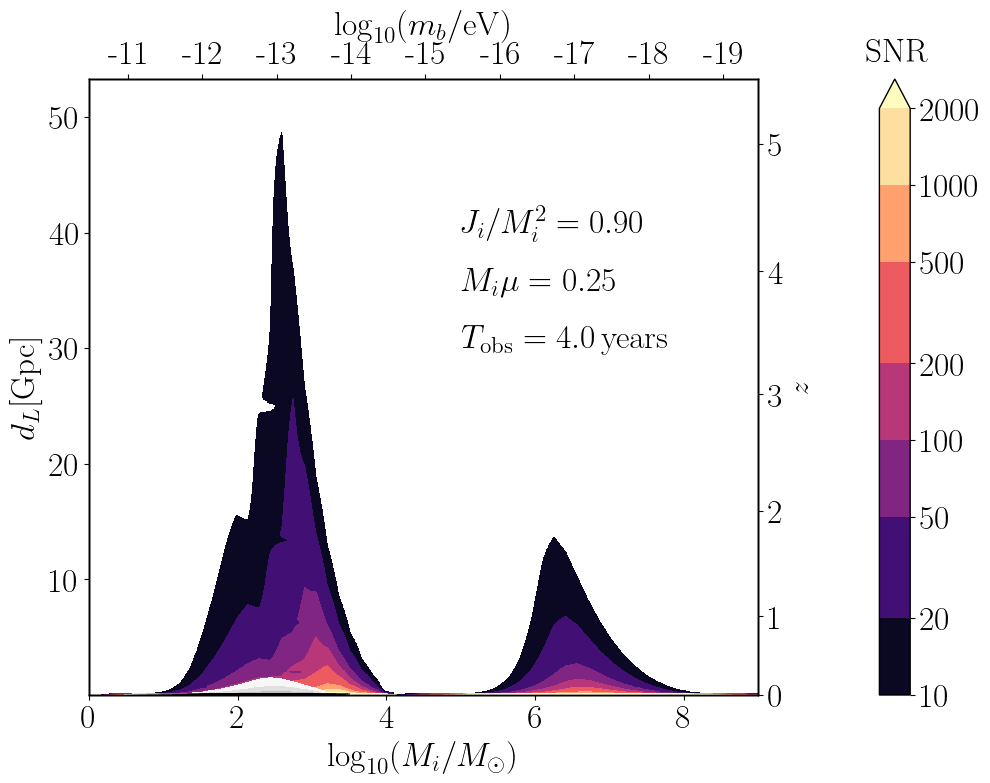

In [9]:
mass_list = np.array(SNRLISA).T[0,:]
#redshift_list = np.array(SNRLISA).T[1,:]
distance_list = np.array(SNRLISA).T[2,:]

snrlist_LISA = np.array(SNRLISA).T[3,:]
snrlist_ET = np.array(SNRET).T[3,:]
snrlist_LIGO = np.array(SNRLIGO).T[3,:]

rangec =[10,20,50,100,200,500,1000,2000]

fig, ax = plt.subplots(1, figsize=(12,8))
ax2 = ax.twiny()

CS = plt.tricontourf(mass_list, distance_list, snrlist_LISA,
                     levels=rangec,cmap='magma', origin='lower', vmin=10, vmax=2000, locator=ticker.LogLocator(),extend='max')
plt.tricontourf(mass_list, distance_list, snrlist_ET,
                     levels=rangec,cmap='magma', origin='lower', vmin=10, vmax=2000, locator=ticker.LogLocator(),extend='max')
plt.tricontourf(mass_list, distance_list, snrlist_LIGO,
                     levels=rangec,cmap='Greys', origin='lower', vmin=10, vmax=2000, locator=ticker.LogLocator(),extend='max')

ax.set_xlabel(r"$\log_{10}(M_i/M_{\odot})$") #source frame mass
ax.set_ylabel(r"$d_L [{\rm Gpc}]$")
ax.set_xlim([0,9])
plt.text(5, 40, r'$J_i/M_i^2=%.2f$' % chi_bh)
plt.text(5, 35, r'$M_i\mu=%.2f $' % alpha)
plt.text(5, 30, r'$T_{\rm obs}=%.1f\,{\rm years}$' % Tobs)

ax2.set_xlim(ax.get_xlim())
m_b=np.array([1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17,1e-18,1e-19])
log10vec=np.vectorize(math.log10)

new_tick_locations = log10vec(alpha*MPL_SI**2/(m_b*EV_SI/C_SI**2)/MSUN_SI)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels([-11,-12,-13,-14,-15,-16,-17,-18,-19])
ax2.set_xlabel(r'$\log_{10}(m_b/{\rm eV})$')

ax3 = ax.twinx()
z=np.array([0,1,2,3,4,5])
ax3.set_ylim(ax.get_ylim())
new_tick_locations_y = cosmo.luminosity_distance(z).value/1000 #luminosity distance in Gpc
ax3.set_yticks(new_tick_locations_y)
ax3.set_yticklabels([0,1,2,3,4,5])
ax3.set_ylabel(r'$z$',fontsize=20)

cb = plt.colorbar(CS, ticks=rangec,pad=0.13)
cb.ax.set_yticklabels(['$10$', '$20$','$50$','$100$','$200$','$500$','$1000$','2000'])  # vertically oriented colorbar
cb.set_label(label=r"SNR", labelpad=-60, y=1.12, rotation=0)

plt.show()

## Imposing $\tau_{\rm sat}<T_{\rm obs}$
Here $T_{\rm obs}$ is the total observation time of a given detector. Impsosing such a constraint is relevant for follow-ups on merger remnants.

In [14]:
#loop over different values of (initial) BH mass and distance to compute SNR, given initial dimensionless BH spin and M\mu.
logMmin=0 #min source frame BH mass, written as log10(M)
logMmax=9 #max source frame BH mass, written as log10(M)
zmin=0.0001 #min cosmo redshift
zmax=3 #max cosmo redshift

chi_bh=0.9 #dimensionless BH spin
alpha=0.25 #M*\mu

Tobs=4 #total operation time of detector in years

SNRLISA=[]
SNRLIGO=[]
SNRET=[]

for z in np.linspace(zmin,zmax, num=150):
    for log10mbh in np.linspace(logMmin, logMmax, num=70):

        #compute cloud
        cloud_spin0=spin0.make_waveform(10**log10mbh, chi_bh, alpha, units="physical+alpha")

        #compute comoving distance given cosmological redshift. notice that h0 is computed with source frame quantities, so we compute it using comoving distances. See Maggiore for details for cosmological effects on GWs
        distance=cosmo.comoving_distance(z).value
        lumdistance=cosmo.luminosity_distance(z).value/1000 #luminosity distance in Gpc

        #get source frame freq and GW amplitude (at maximum amplitude)
        h0, fgw = cloud_spin0.strain_char(0,distance), cloud_spin0.freq_gw(0)

        #to get a quick estimate of SNR we average over sky, polarization and inclination angle.
        #I use eq. 16 in https://arxiv.org/pdf/1803.01944.pdf for the inclination angle average.
        #Notice that S_h for LISA already includes the sky and polarization averaged signal response function R(f) in it, according to eq.(2) in https://arxiv.org/pdf/1803.01944.pdf,
        #on the other hand for LIGO and ET, "S_n" does not include the response function. I use eq. 7 in https://arxiv.org/pdf/1803.01944.pdf when computing the sky and polarization averaged signal.
        #all of this is essentially eq. 81 and 84 in https://arxiv.org/pdf/2108.01167.pdf. See also notebook "SNR_calc.nb" in school repository.
        #Furthermore, for LIGO I'm adding an additional factor \sqrt(2) to account for two detectors
        #In addition for ET, I'm adding a factor 3/2, to account for the triangle shape that gives a factor \sqrt(3)/2 and the fact that there are effectively 3 detectors that gives a factor \sqrt(3), see e.g. discussion in page 8 of https://arxiv.org/pdf/2303.15923.pdf
        havLISA=h0*np.sqrt(4/5)
        havET=h0*(2/5)*(3/2)
        havLIGO=h0*2/5*np.sqrt(2)

        fdetector=fgw/(1+z) #redshifted frequency at the detector
        tgw=cloud_spin0.gw_time() #gw half-life time
        tgwredshift=tgw*(1+z) #take into account cosmological redshift in duration of the signal in order to compare with observation time

        tsat=(cloud_spin0.cloud_growth_time())/year #time for cloud to reach saturation. Note that cloud_spin0.cloud_growth_time() gives times in second, so I'm transforming in units of years, in order to compare with Tobs which is given in years
        tsat_redshift=tsat*(1+z) #take into account cosmological redshift in order to compare with observation time.
        Tobsmax=Tobs-tsat_redshift #I'm assuming that before saturation signal is negligible, such that if signal takes a time tsat_redshift to reach saturation then the maximum time one can be observe the signal from a cloiud formed around a merger remnant is Tobs-tsat_redshift.
        #If tsat_redshift>Tobs, then it means that instability timescale is too long and one does not expect any signal emitted by a merger remnant during the observation time Tobs. Function SNRav() returns SNR=0 if Tobsreal<0, effectively discarding such cases.

        SNR_lisa=SNRav(hav=havLISA, f=fdetector,PSD=psd_data['LISA'], tgw=tgwredshift, Tobs = Tobsmax)
        SNR_et=SNRav(hav=havET, f=fdetector,PSD=psd_data['ETD'], tgw=tgwredshift, Tobs = Tobsmax)
        SNR_ligo=SNRav(hav=havLIGO, f=fdetector,PSD=psd_data['aLIGO'], tgw=tgwredshift, Tobs = Tobsmax)
        if SNR_lisa==0:
            SNR_lisa=1e-10 # this is to avoid errors when doing the waterfall plot
        if SNR_et==0:
            SNR_et=1e-10 # this is to avoid errors when doing the waterfall plot
        if SNR_ligo==0:
            SNR_ligo=1e-10 # this is to avoid errors when doing the waterfall plot

        SNRLISA.append([log10mbh,z,lumdistance,SNR_lisa])
        SNRET.append([log10mbh,z,lumdistance,SNR_et])
        SNRLIGO.append([log10mbh,z,lumdistance,SNR_ligo])

**Contour plot**

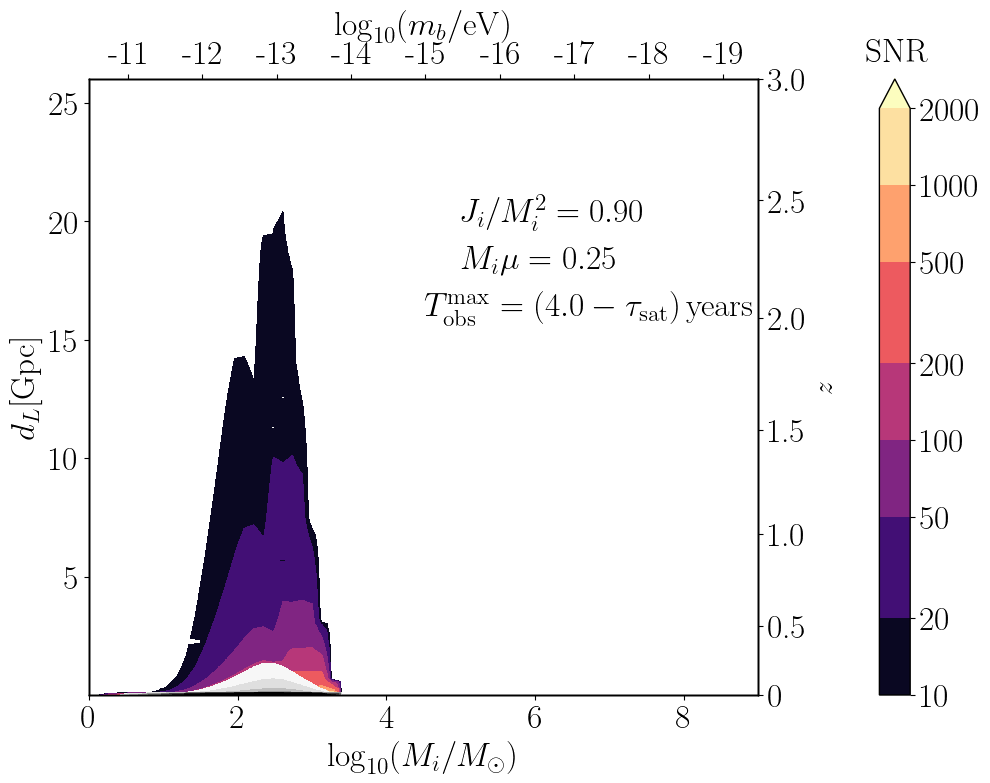

In [15]:
mass_list = np.array(SNRLISA).T[0,:]
distance_list = np.array(SNRLISA).T[2,:]

snrlist_LISA = np.array(SNRLISA).T[3,:]
snrlist_ET = np.array(SNRET).T[3,:]
snrlist_LIGO = np.array(SNRLIGO).T[3,:]

rangec =[10,20,50,100,200,500,1000,2000]

fig, ax = plt.subplots(1, figsize=(12,8))
ax2 = ax.twiny()

CS = plt.tricontourf(mass_list, distance_list, snrlist_LISA,
                     levels=rangec,cmap='magma', origin='lower', vmin=10, vmax=2000, locator=ticker.LogLocator(),extend='max')
plt.tricontourf(mass_list, distance_list, snrlist_ET,
                     levels=rangec,cmap='magma', origin='lower', vmin=10, vmax=2000, locator=ticker.LogLocator(),extend='max')
plt.tricontourf(mass_list, distance_list, snrlist_LIGO,
                     levels=rangec,cmap='Greys', origin='lower', vmin=10, vmax=2000, locator=ticker.LogLocator(),extend='max')

ax.set_xlabel(r"$\log_{10}(M_i/M_{\odot})$") #source frame mass
ax.set_ylabel(r"$d_L [{\rm Gpc}]$")
ax.set_xlim([0,9])
plt.text(5, 20, r'$J_i/M_i^2=%.2f$' % chi_bh)
plt.text(5, 18, r'$M_i\mu=%.2f $' % alpha)
plt.text(4.5, 16, r'$T^{\rm max}_{\rm obs}=(%.1f-\tau_{\rm sat})\,{\rm years}$' % Tobs)

ax2.set_xlim(ax.get_xlim())
m_b=np.array([1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17,1e-18,1e-19])
log10vec=np.vectorize(math.log10)

new_tick_locations = log10vec(alpha*MPL_SI**2/(m_b*EV_SI/C_SI**2)/MSUN_SI)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels([-11,-12,-13,-14,-15,-16,-17,-18,-19])
ax2.set_xlabel(r'$\log_{10}(m_b/{\rm eV})$')

ax3 = ax.twinx()
z=np.array([0,0.5,1.0,1.5,2.0,2.5,3.0])
ax3.set_ylim(ax.get_ylim())
new_tick_locations_y = cosmo.luminosity_distance(z).value/1000 #luminosity distance in Gpc
ax3.set_yticks(new_tick_locations_y)
ax3.set_yticklabels([0,0.5,1.0,1.5,2.0,2.5,3.0])
ax3.set_ylabel(r'$z$',fontsize=20)

cb = plt.colorbar(CS, ticks=rangec,pad=0.13)
cb.ax.set_yticklabels(['$10$', '$20$','$50$','$100$','$200$','$500$','$1000$','2000'])  # vertically oriented colorbar
cb.set_label(label=r"SNR", labelpad=-60, y=1.12, rotation=0)

plt.show()

# SNR for vector clouds

In [16]:
#initialize vector (spin 1) cloud model
spin1 = UltralightBoson(spin=1, model="relativistic")

### Requiring that $\tau_{\rm sat}<t_z$
Here $\tau_{\rm sat}$ is the time it takes for the boson cloud to grow up to saturation and $t_z$ is the age of the Universe at a given redshift z. This constraint ensures that a boson cloud has time to grow within the age of the Universe (this is just an approximation, one could chose other more relevant astrophysical timescales)

In [17]:
#loop over different values of (initial) BH mass and distance to compute SNR, given initial dimensionless BH spin and M\mu.
logMmin=0 #min source frame BH mass, written as log10(M)
logMmax=9 #max source frame BH mass, written as log10(M)
zmin=0.0001 #min cosmo redshift
zmax=10 #max cosmo redshift

chi_bh=0.9 #dimensionless BH spin
alpha=0.25 #M*\mu

Tobs=4 #observation time in years

SNRLISA=[]
SNRLIGO=[]
SNRET=[]

for z in np.linspace(zmin,zmax, num=200):
    for log10mbh in np.linspace(logMmin, logMmax, num=60):

        #compute cloud
        cloud_spin1=spin1.make_waveform(10**log10mbh, chi_bh, alpha, units="physical+alpha")

        #compute comoving distance given cosmological redshift. notice that h0 is computed with source frame quantities, so we compute it using comoving distances. See Maggiore for details for cosmological effects on GWs
        distance=cosmo.comoving_distance(z).value
        lumdistance=cosmo.luminosity_distance(z).value/1000 #luminosity distance in Gpc

        #get source frame freq and GW amplitude (at maximum amplitude)
        h0, fgw = cloud_spin1.strain_char(0,distance), cloud_spin1.freq_gw(0)

        #see previous discussion for explanation of the different factors
        havLISA=h0*np.sqrt(4/5)
        havET=h0*(2/5)*(3/2)
        havLIGO=h0*2/5*np.sqrt(2)

        fdetector=fgw/(1+z) #redshifted frequency at the detector
        tgw=cloud_spin1.gw_time() #gw half-life time
        tgwredshift=tgw*(1+z) #take into account cosmological redshift in duration of the signal
        tsat=cloud_spin1.cloud_growth_time() #time for cloud to reach saturation in seconds.

         #(cosmo.age(z).value gives age of the Universe at redshift z in Gyr)
        if tsat> cosmo.age(z).value*1e9*year: #if time for cloud to reach saturation is larger than age of the Universe (at the given redshift where the BH is) then cloud doesn't have time to grow, so discard those cases
            SNR_lisa=0
            SNR_et=0
            SNR_ligo=0
        else:
            SNR_lisa=SNRav(hav=havLISA, f=fdetector,PSD=psd_data['LISA'], tgw=tgwredshift, Tobs = Tobs)
            SNR_et=SNRav(hav=havET, f=fdetector,PSD=psd_data['ETD'], tgw=tgwredshift, Tobs = Tobs)
            SNR_ligo=SNRav(hav=havLIGO, f=fdetector,PSD=psd_data['aLIGO'], tgw=tgwredshift, Tobs = Tobs)
       
        if SNR_lisa==0:
            SNR_lisa=1e-10 # this is to avoid errors when doing the waterfall plot
        if SNR_et==0:
            SNR_et=1e-10 # this is to avoid errors when doing the waterfall plot
        if SNR_ligo==0:
            SNR_ligo=1e-10 # this is to avoid errors when doing the waterfall plot

        SNRLISA.append([log10mbh,z,lumdistance,SNR_lisa])
        SNRET.append([log10mbh,z,lumdistance,SNR_et])
        SNRLIGO.append([log10mbh,z,lumdistance,SNR_ligo])


In [18]:
#just to check that I am indeed considering a cloud with m=1
cloud_spin1.azimuthal_num()

1

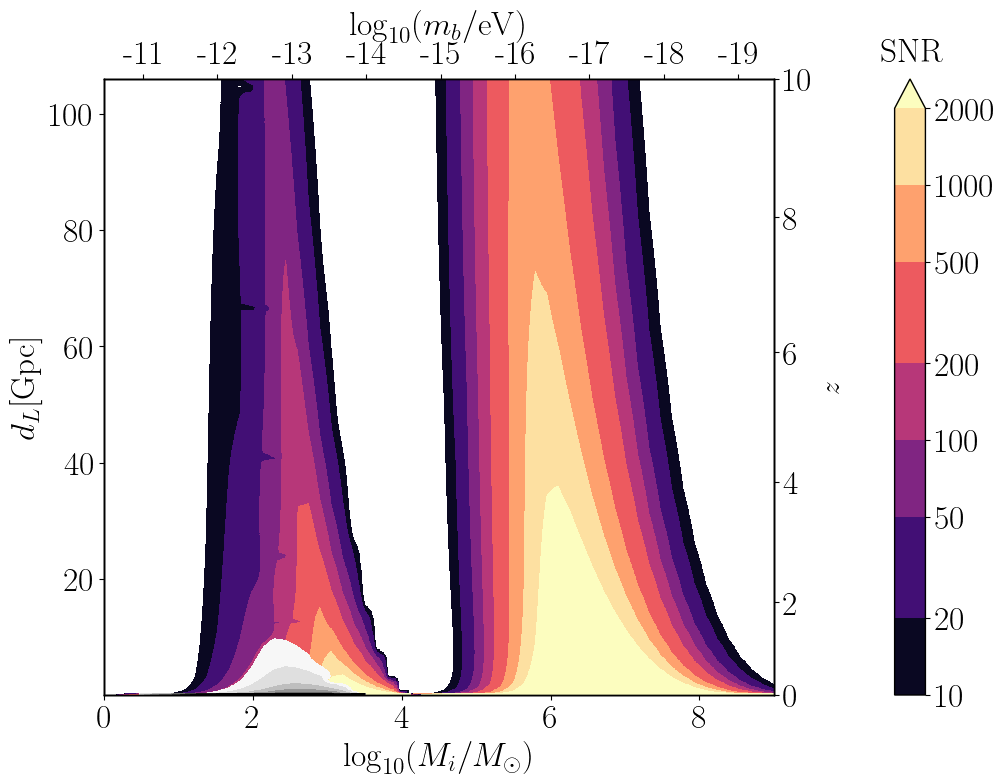

In [19]:
mass_list = np.array(SNRLISA).T[0,:]
#redshift_list = np.array(SNRLISA).T[1,:]
distance_list = np.array(SNRLISA).T[2,:]

snrlist_LISA = np.array(SNRLISA).T[3,:]
snrlist_ET = np.array(SNRET).T[3,:]
snrlist_LIGO = np.array(SNRLIGO).T[3,:]

rangec =[10,20,50,100,200,500,1000,2000]

fig, ax = plt.subplots(1, figsize=(12,8))
ax2 = ax.twiny()

CS = plt.tricontourf(mass_list, distance_list, snrlist_LISA,
                     levels=rangec,cmap='magma', origin='lower', vmin=10, vmax=2000, locator=ticker.LogLocator(),extend='max')
plt.tricontourf(mass_list, distance_list, snrlist_ET,
                     levels=rangec,cmap='magma', origin='lower', vmin=10, vmax=2000, locator=ticker.LogLocator(),extend='max')
plt.tricontourf(mass_list, distance_list, snrlist_LIGO,
                     levels=rangec,cmap='Greys', origin='lower', vmin=10, vmax=2000, locator=ticker.LogLocator(),extend='max')

ax.set_xlabel(r"$\log_{10}(M_i/M_{\odot})$") #source frame mass
ax.set_ylabel(r"$d_L [{\rm Gpc}]$")
ax.set_xlim([0,9])
#plt.text(3, 40, r'$J_i/M_i^2=%.2f,\,\,M_i\mu=%.2f $' % (chi_bh, alpha))
#plt.text(5, 35, r'$T_{\rm obs}=%.1f\,{\rm years}$' % Tobs)

ax2.set_xlim(ax.get_xlim())
m_b=np.array([1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17,1e-18,1e-19])
log10vec=np.vectorize(math.log10)

new_tick_locations = log10vec(alpha*MPL_SI**2/(m_b*EV_SI/C_SI**2)/MSUN_SI)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels([-11,-12,-13,-14,-15,-16,-17,-18,-19])
ax2.set_xlabel(r'$\log_{10}(m_b/{\rm eV})$')

ax3 = ax.twinx()
z=np.array([0,2,4,6,8,10])
ax3.set_ylim(ax.get_ylim())
new_tick_locations_y = cosmo.luminosity_distance(z).value/1000 #luminosity distance in Gpc
ax3.set_yticks(new_tick_locations_y)
ax3.set_yticklabels([0,2,4,6,8,10])
ax3.set_ylabel(r'$z$',fontsize=20)

cb = plt.colorbar(CS, ticks=rangec,pad=0.13)
cb.ax.set_yticklabels(['$10$', '$20$','$50$','$100$','$200$','$500$','$1000$','2000'])  # vertically oriented colorbar
cb.set_label(label=r"SNR", labelpad=-60, y=1.12, rotation=0)

plt.show()

## Imposing $\tau_{\rm sat}<T_{\rm obs}$
Here $T_{\rm obs}$ is the total observation time of a given detector. Impsosing such a constraint is relevant for follow-ups on merger remnants.

In [22]:
#loop over different values of (initial) BH mass and distance to compute SNR, given initial dimensionless BH spin and M\mu.
logMmin=0 #min source frame BH mass, written as log10(M)
logMmax=9 #max source frame BH mass, written as log10(M)
zmin=0.0001 #min cosmo redshift
zmax=10 #max cosmo redshift

chi_bh=0.9 #dimensionless BH spin
alpha=0.25 #M*\mu

Tobs=4 #observation time in years

SNRLISA=[]
SNRLIGO=[]
SNRET=[]

for z in np.linspace(zmin,zmax, num=150):
    for log10mbh in np.linspace(logMmin, logMmax, num=70):

        #compute cloud
        cloud_spin1=spin1.make_waveform(10**log10mbh, chi_bh, alpha, units="physical+alpha")

        #compute comoving distance given cosmological redshift. notice that h0 is computed with source frame quantities, so we compute it using comoving distances. See Maggiore for details for cosmological effects on GWs
        distance=cosmo.comoving_distance(z).value
        lumdistance=cosmo.luminosity_distance(z).value/1000 #luminosity distance in Gpc

        #get source frame freq and GW amplitude (at maximum amplitude)
        h0, fgw = cloud_spin1.strain_char(0,distance), cloud_spin1.freq_gw(0)

        #to get a quick estimate of SNR we average over sky, polarization and inclination angle.
        #I use eq. 16 in https://arxiv.org/pdf/1803.01944.pdf for the inclination angle average.
        #Notice that S_h for LISA already includes the sky and polarization averaged signal response function R(f) in it, according to eq.(2) in https://arxiv.org/pdf/1803.01944.pdf,
        #on the other hand for LIGO and ET, "S_n" does not include the response function. I use eq. 7 in https://arxiv.org/pdf/1803.01944.pdf when computing the sky and polarization averaged signal.
        #all of this is essentially eq. 81 and 84 in https://arxiv.org/pdf/2108.01167.pdf. See also notebook "SNR_calc.nb" in school repository.
        #Furthermore, for LIGO I'm adding an additional factor \sqrt(2) to account for two detectors
        #In addition for ET, I'm adding a factor 3/2, to account for the triangle shape that gives a factor \sqrt(3)/2 and the fact that there are effectively 3 detectors that gives a factor \sqrt(3), see e.g. discussion in page 8 of https://arxiv.org/pdf/2303.15923.pdf
        havLISA=h0*np.sqrt(4/5)
        havET=h0*(2/5)*(3/2)
        havLIGO=h0*2/5*np.sqrt(2)

        fdetector=fgw/(1+z) #redshifted frequency at the detector
        tgw=cloud_spin1.gw_time() #gw half-life time
        tgwredshift=tgw*(1+z) #take into account cosmological redshift in duration of the signal in order to compare with observation time

        tsat=(cloud_spin1.cloud_growth_time())/year #time for cloud to reach saturation. Note that cloud_spin0.cloud_growth_time() gives times in second, so I'm transforming in units of years, in order to compare with Tobs which is given in years
        tsat_redshift=tsat*(1+z) #take into account cosmological redshift in order to compare with observation time.
        Tobsmax=Tobs-tsat_redshift #I'm assuming that before saturation signal is negligible, such that if signal takes a time tsat_redshift to reach saturation then the maximum time one can be observe the signal from a cloiud formed around a merger remnant is Tobs-tsat_redshift.
        #If tsat_redshift>Tobs, then it means that instability timescale is too long and one does not expect any signal emitted by a merger remnant during the observation time Tobs. Function SNRav() returns SNR=0 if Tobsreal<0, effectively discarding such cases.

        SNR_lisa=SNRav(hav=havLISA, f=fdetector,PSD=psd_data['LISA'], tgw=tgwredshift, Tobs = Tobsmax)
        SNR_et=SNRav(hav=havET, f=fdetector,PSD=psd_data['ETD'], tgw=tgwredshift, Tobs = Tobsmax)
        SNR_ligo=SNRav(hav=havLIGO, f=fdetector,PSD=psd_data['aLIGO'], tgw=tgwredshift, Tobs = Tobsmax)
        if SNR_lisa==0:
            SNR_lisa=1e-10 # this is to avoid errors when doing the waterfall plot
        if SNR_et==0:
            SNR_et=1e-10 # this is to avoid errors when doing the waterfall plot
        if SNR_ligo==0:
            SNR_ligo=1e-10 # this is to avoid errors when doing the waterfall plot

        SNRLISA.append([log10mbh,z,lumdistance,SNR_lisa])
        SNRET.append([log10mbh,z,lumdistance,SNR_et])
        SNRLIGO.append([log10mbh,z,lumdistance,SNR_ligo])

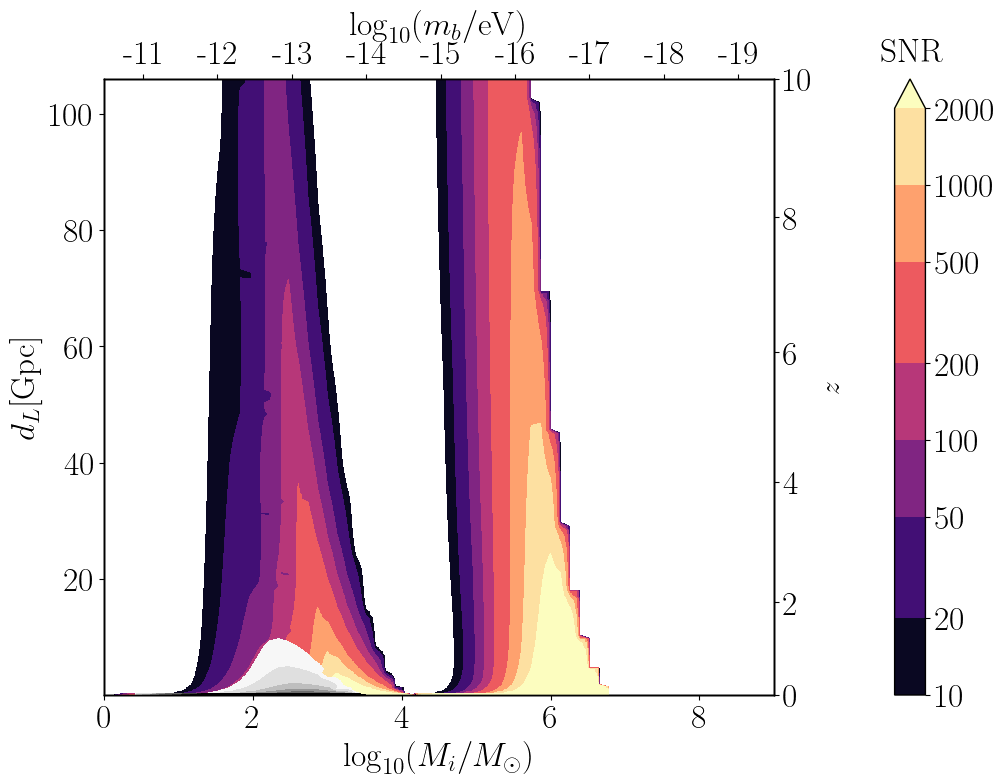

In [24]:
mass_list = np.array(SNRLISA).T[0,:]
distance_list = np.array(SNRLISA).T[2,:]

snrlist_LISA = np.array(SNRLISA).T[3,:]
snrlist_ET = np.array(SNRET).T[3,:]
snrlist_LIGO = np.array(SNRLIGO).T[3,:]

rangec =[10,20,50,100,200,500,1000,2000]

fig, ax = plt.subplots(1, figsize=(12,8))
ax2 = ax.twiny()

CS = plt.tricontourf(mass_list, distance_list, snrlist_LISA,
                     levels=rangec,cmap='magma', origin='lower', vmin=10, vmax=2000, locator=ticker.LogLocator(),extend='max')
plt.tricontourf(mass_list, distance_list, snrlist_ET,
                     levels=rangec,cmap='magma', origin='lower', vmin=10, vmax=2000, locator=ticker.LogLocator(),extend='max')
plt.tricontourf(mass_list, distance_list, snrlist_LIGO,
                     levels=rangec,cmap='Greys', origin='lower', vmin=10, vmax=2000, locator=ticker.LogLocator(),extend='max')

ax.set_xlabel(r"$\log_{10}(M_i/M_{\odot})$") #source frame mass
ax.set_ylabel(r"$d_L [{\rm Gpc}]$")
ax.set_xlim([0,9])
#plt.text(3, 40, r'$J_i/M_i^2=%.2f,\,\,M_i\mu=%.2f $' % (chi_bh, alpha))
#plt.text(4.5, 35, r'$T^{\rm max}_{\rm obs}=(%.1f-\tau_{\rm sat})\,{\rm years}$' % Tobs)

ax2.set_xlim(ax.get_xlim())
m_b=np.array([1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17,1e-18,1e-19])
log10vec=np.vectorize(math.log10)

new_tick_locations = log10vec(alpha*MPL_SI**2/(m_b*EV_SI/C_SI**2)/MSUN_SI)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels([-11,-12,-13,-14,-15,-16,-17,-18,-19])
ax2.set_xlabel(r'$\log_{10}(m_b/{\rm eV})$')

ax3 = ax.twinx()
z=np.array([0,2,4,6,8,10])
ax3.set_ylim(ax.get_ylim())
new_tick_locations_y = cosmo.luminosity_distance(z).value/1000 #luminosity distance in Gpc
ax3.set_yticks(new_tick_locations_y)
ax3.set_yticklabels([0,2,4,6,8,10])
ax3.set_ylabel(r'$z$',fontsize=20)

cb = plt.colorbar(CS, ticks=rangec,pad=0.13)
cb.ax.set_yticklabels(['$10$', '$20$','$50$','$100$','$200$','$500$','$1000$','2000'])  # vertically oriented colorbar
cb.set_label(label=r"SNR", labelpad=-60, y=1.12, rotation=0)

plt.show()